# JEM092 Asset Pricing - Homework 1

### Group 82780095

Petr Dvořáček, Jan Kubal, Matyáš Mattanelli

---

## Task 1

In [1]:
#Loading the necessary libraries
suppressPackageStartupMessages({
    library(quantmod) #getSymbols function
    library(rvest) #Web scraping
    library(stringr) #Regular expressions
    library(xts) #Managing xts objects
    library(V8) #Evaluating html variables
    library(PortfolioAnalytics) #GMVP and efficient frontier
    library(ROI.plugin.glpk) #Portfolio optimization
    library(ROI.plugin.quadprog) #Portfolio optimization
})

Warning message:
"package 'rvest' was built under R version 4.1.3"
Warning message:
"package 'V8' was built under R version 4.1.3"
Warning message:
"package 'PortfolioAnalytics' was built under R version 4.1.3"
Warning message:
"package 'PerformanceAnalytics' was built under R version 4.1.3"


In [2]:
#Loading the assigned csv file
tickers_to_download <- read.csv("data_HW1/82780095_data_download.csv")
no_of_tickers <- nrow(tickers_to_download) #Storing the number of tickers for future use

#### Adjusted close price and Volume

In [3]:
#Downloading the data from Yahoo Finance (runtime 3m 15s)
yahoo_data_list <- vector("list", no_of_tickers) #Initializing an empty list for the data
options("getSymbols.warning4.0"=FALSE) #Command to prevent an annoying message from appearing
for (i in 1:no_of_tickers) { #Looping through the tickers
    yahoo_data_list[[i]] <- getSymbols(tickers_to_download[i, 2], src="yahoo", auto.assign = F, from = "2007-01-01", to = "2022-03-01")
}

In [4]:
#Checking that we have adjusted close price and volume in appropriate columns for each ticker
check_col_name <- function(ticker_data, pattern, column_no) { #Defining a function to check if a column name matches a pattern
    ifelse(strsplit(names(ticker_data)[column_no], "\\.")[[1]][2] == pattern, return(T), return(F)) 
}
#Applying the function on all tickers for both Volume and Adjusted price
print(paste("Volume in the 5th column: ", sum(unlist(lapply(yahoo_data_list, check_col_name, pattern = "Volume", column_no = 5))), sep = ""), quote = F)
print(paste("Adjusted Close Price in the 6th column: ", sum(unlist(lapply(yahoo_data_list, check_col_name, pattern = "Adjusted", column_no = 6))), sep = ""), quote = F)

[1] Volume in the 5th column: 250
[1] Adjusted Close Price in the 6th column: 250


In [5]:
#Merging the available data into a single xts object
merged_yahoo_data <- merge.xts(yahoo_data_list[[1]][, 5:6], yahoo_data_list[[2]][, 5:6]) #Initial merge, adjusted close price and volume are in the 5th and 6th columns, respectively
for (iter in 3:no_of_tickers) { #Loop through the rest of the tickers and append each to the merged object
    merged_yahoo_data <- merge.xts(merged_yahoo_data, yahoo_data_list[[iter]][, 5:6])
}

In [6]:
#Checking that the number of columns is correct
ncol(merged_yahoo_data) == no_of_tickers * 2 #Two columns for each ticker

[1] TRUE

In [7]:
#Exporting to csv just in case
#write.zoo(merged_yahoo_data, file = "adjusted_and_volume.csv", sep = ",")

#### Book value per share

In [8]:
#Getting the urls (runtime 1m47s)
urls_bv <- rep(NA, no_of_tickers) #Empty vector for the urls
for (iter in 1:no_of_tickers) { #Loop through all the tickers
    patt <- curlGetHeaders(paste0("https://www.macrotrends.net/stocks/charts/", tickers_to_download[iter, 2]))[5] #Save the response
    name_and_ticker <- str_extract(patt, paste0(tickers_to_download[iter, 2], "/.*/")) #Extract the relevant pattern from the string
    urls_bv[iter] <- paste0("https://www.macrotrends.net/stocks/charts/", name_and_ticker, "price-book") #Complete the url and save it
}

In [9]:
#Downloading the data (runtime 3m6s)
bv_per_share_data <- vector("list", no_of_tickers) #Empty list to store the data
for (iter in 1:no_of_tickers) { #Loop through all tickers
  if (tickers_to_download[iter, 2] == "LUMN") {
    next #Temporarily skipping one ticker since the site does not exist
  }
  html_request <- read_html(urls_bv[iter]) #Sending the request
  trs <- html_request %>% 
    html_element("table") %>% #Finding the table
    html_element("tbody") %>% #FInding the body of the table
    html_elements("tr") #Finding the rows of the table
  dates <- rep(NA, length(trs)) #Empty vector to store the dates
  values <- rep(NA, length(trs)) #Empty vector to store the values
  for (iter2 in 1:length(trs)) { #Looping through all the rows
    tds <- html_elements(trs[iter2], "td") #Extracting the cells within each row
    dates[iter2] <- html_text(tds)[1] #First cell is the date
    values[iter2] <- as.numeric(gsub("\\$","",html_text(tds)[3])) #Third cell is book value per share
  }
  dates <- as.Date(dates) #Convert dates from string to Date format
  xts_object <- xts(x = values, order.by = dates) #Create an xts object from the results
  names(xts_object) <- paste0(tickers_to_download[iter, 2], ".BV_per_share") #Name it
  bv_per_share_data[[iter]] <-  xts_object #Store the results
}

In [10]:
#Merging the individual tickers together
merged_bv_per_share_data <- merge.xts(bv_per_share_data[[1]], bv_per_share_data[[2]]) #Initial merge
for (iter in 3:no_of_tickers) {
    if (iter==72) {
        next #Temporarily skipping LUMN
    }
    merged_bv_per_share_data <- merge.xts(merged_bv_per_share_data, bv_per_share_data[[iter]])
}

In [11]:
#Exporting to csv just in case
#write.zoo(merged_bv_per_share_data, file = "bv_per_share.csv", sep = ",")

#### Market capitalization

In [12]:
#Downloading the data (runtime 1m34s)
market_cap_data <- vector("list", no_of_tickers)
for (iter in 1:no_of_tickers) { #Looping through all tickers
    html_request <- read_html(paste0("https://www.macrotrends.net/assets/php/market_cap.php?t=", tickers_to_download[iter, 2])) #Sending a request
    script <- html_request %>% #Extracting the relevant element and converting it to text
        html_element("body") %>%
        html_element("script") %>%
        html_text(trim = T)
    ctx <- v8() #The extracted text contains a variable which can be evaluated using JavaScript so we initialize an execution environment
    ctx$eval(str_extract(script,".*]")) #Evaluating the text. The function inside extracts the part that is relevant for us
    extracted_data <- ctx$get("chartData") #Extracting the variable (returns a data frame)
    xts_object <- xts(x = extracted_data[, 2], order.by = as.Date(extracted_data[, 1])) #Saving as an xts object
    names(xts_object) <- paste0(tickers_to_download[iter,2], ".Market_Cap") #Renaming
    market_cap_data[[iter]] <- xts_object #Storing
}

In [13]:
#Merging the data
merged_market_cap_data <- merge.xts(market_cap_data[[1]], market_cap_data[[2]]) #Initial merge
for (iter in 3:no_of_tickers) { #Looping through all the tickers
    merged_market_cap_data <- merge.xts(merged_market_cap_data, market_cap_data[[iter]])
}

In [14]:
#Exporting to csv just in case
#write.zoo(merged_market_cap_data, file = "market_cap.csv", sep = ",")

#### Merging it all together

In [15]:
#Merging adjusted prices, volume, book value per share, and market capitalization
semifinal_dataset <- merge.xts(merged_yahoo_data, merged_bv_per_share_data, merged_market_cap_data)

In [16]:
#Exporting to csv
write.zoo(semifinal_dataset, file = "semifinal_dataset.csv", sep = ",")

## Task 2

In [17]:
#Loading the 20 tickers
tickers_20 <- read.csv("data_HW1/82780095_rand_download.csv")

In [18]:
#Finding the row number for each ticker
iters <- rep(NA, 20)
for (i in 1:20) {   
    iters[i] <- tickers_to_download[tickers_to_download[, 2] == tickers_20[i, 2], 1]
}

In [19]:
#Getting data for the relevant tickers and adjusting it
task2_data <- vector("list", 20) #Empty list for the data
for (i in 1:20) { #Looping through the tickers
    task2_data[[i]] <- to.monthly(yahoo_data_list[[iters[i]]]["2014-12/"], name = tickers_20[i, 2])[, 6] #Extracting data from 2015 and later and then converting it to monthly. Keeping only the Adjusted price 
}

In [20]:
task2_data

[[1]]
         PM.Adjusted
Dec 2014    56.33436
Jan 2015    55.49745
Feb 2015    57.37873
Mar 2015    52.76218
Apr 2015    58.46355
May 2015    58.18337
Jun 2015    56.83588
Jul 2015    60.63582
Aug 2015    56.57357
Sep 2015    56.96121
Oct 2015    63.47375
Nov 2015    62.74852
Dec 2015    63.87143
Jan 2016    65.39719
Feb 2016    66.13827
Mar 2016    72.02749
Apr 2016    72.03481
May 2016    72.44595
Jun 2016    75.43546
Jul 2016    74.35273
Aug 2016    74.10799
Sep 2016    72.84442
Oct 2016    72.26000
Nov 2016    66.14592
Dec 2016    69.33953
Jan 2017    72.85616
Feb 2017    82.87550
Mar 2017    86.35374
Apr 2017    84.77811
May 2017    91.63134
Jun 2017    90.60558
Jul 2017    90.03471
Aug 2017    90.20445
Sep 2017    86.45432
Oct 2017    81.49340
Nov 2017    80.02146
Dec 2017    83.10239
Jan 2018    84.34520
Feb 2018    81.45058
Mar 2018    79.02960
Apr 2018    65.19545
May 2018    63.23959
Jun 2018    65.10151
Jul 2018    69.58461
Aug 2018    62.80353
Sep 2018    66.67797
Oct 201

In [21]:
#Converting to returns and merging into a single xts object
task2_data_returns <- vector("list", 20)
for (i in 1:20) {
    task2_data_returns[[i]] <- (task2_data[[i]] - lag(task2_data[[i]]))/lag(task2_data[[i]])
}
#Merging
final_returns <- merge.xts(task2_data_returns[[1]], task2_data_returns[[2]])
for (i in 3:20) {
    final_returns <- merge.xts(final_returns, task2_data_returns[[i]])
}
names(final_returns) <- gsub(".Adjusted", "", names(final_returns)) #Renaming for conciseness

In [22]:
final_returns <- final_returns["2015/"]

In [23]:
#Calculating the Global Minimum Variance Portfolio
pspec <- portfolio.spec(assets = tickers_20[, 2]) #Specifying the stock names
initial_portfolio <- add.constraint(portfolio = pspec, type = "full_investment") #Adding a constraint
minvar <- add.objective(portfolio = initial_portfolio, type = "risk", name = "var") #Adding an objective
opt_minvar <- optimize.portfolio(R = final_returns, portfolio = minvar, optimize_method = "ROI") #Optimizing

In [24]:
print(opt_minvar)

***********************************
PortfolioAnalytics Optimization
***********************************

Call:
optimize.portfolio(R = final_returns, portfolio = minvar, optimize_method = "ROI")

Optimal Weights:
     PM    AAPL      KO     WAT    BKNG     AZO    ULTA     MGM     PNR    IDXX 
 0.0032  0.0733  0.3178 -0.0374  0.0008  0.0775  0.0237 -0.1976  0.0213  0.1129 
    TFC     AVY    HSIC    EXPE    INTC     ADI     OMC     DTE     RHI     AMP 
 0.2216  0.0964 -0.0243 -0.0496  0.1628  0.0571  0.1814  0.1707 -0.0688 -0.1430 

Objective Measure:
 StdDev 
0.02933 





In [25]:
#Constructing portfolios A and B
pspecA <- portfolio.spec(assets = tickers_20[1:10, 2])
pspecB <- portfolio.spec(assets = tickers_20[11:20, 2])
portfolioA <- add.constraint(portfolio = pspecA, type = "box", min = min(opt_minvar$weights[1:10]), max = 1)
portfolioB <- add.constraint(portfolio = pspecB, type = "box", min = min(opt_minvar$weights[11:20]), max = 1)

In [26]:
#saving subsets of returns
final_returnsA <- final_returns[, 1:10]
final_returnsB <- final_returns[, 11:20]

In [27]:
#Creating the efficient frontier
eff_front_A <- create.EfficientFrontier(R = final_returnsA, portfolio = portfolioA, type = 'mean-var')
eff_front_B <- create.EfficientFrontier(R = final_returnsB, portfolio = portfolioB, type = 'mean-var')

Warning message:
"executing %dopar% sequentially: no parallel backend registered"


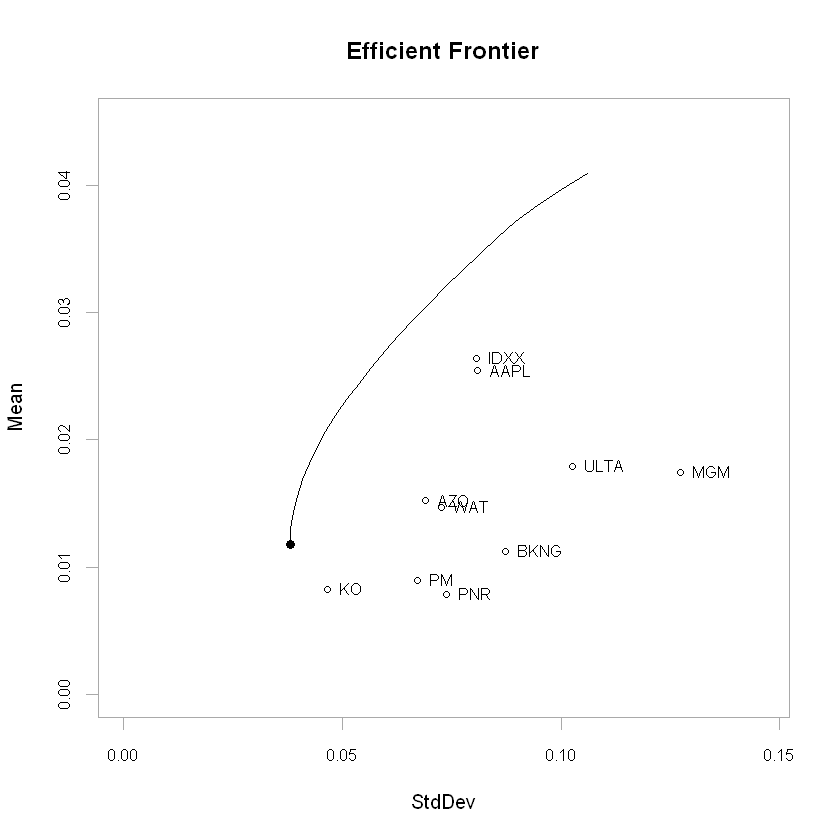

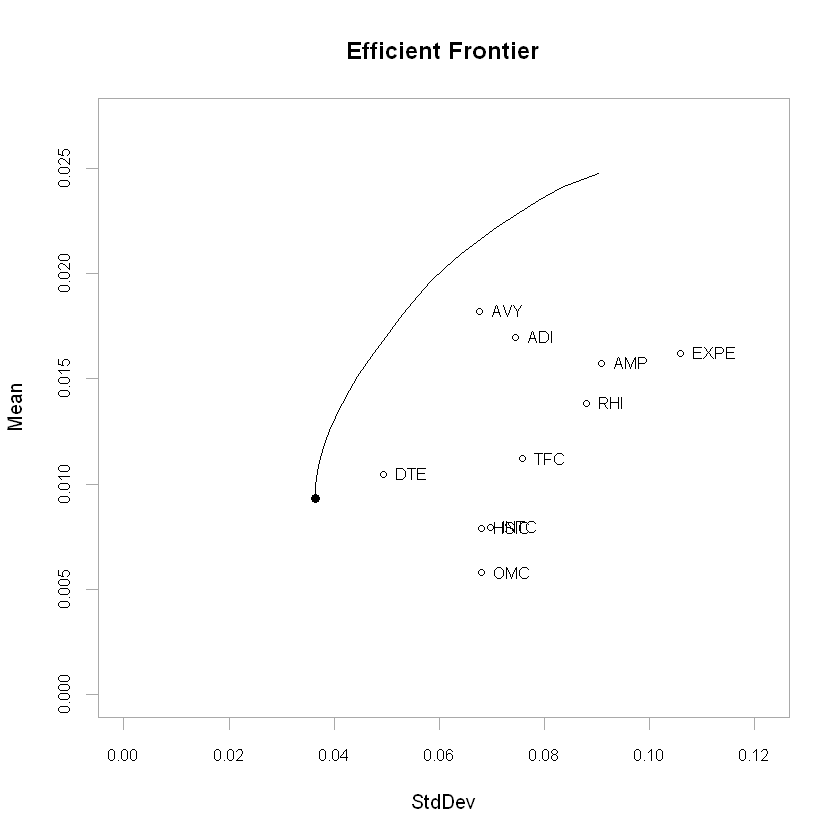

In [28]:
#Plotting the Efficient Frontier

chart.EfficientFrontier(eff_front_A, match.col = 'StdDev', type = 'l', tangent.line = FALSE, rf = NULL)
chart.EfficientFrontier(eff_front_B, match.col = 'StdDev', type = 'l', tangent.line = FALSE, rf = NULL)


In [29]:
AB_comb <- combine.portfolios(list(portfolioA, portfolioB))

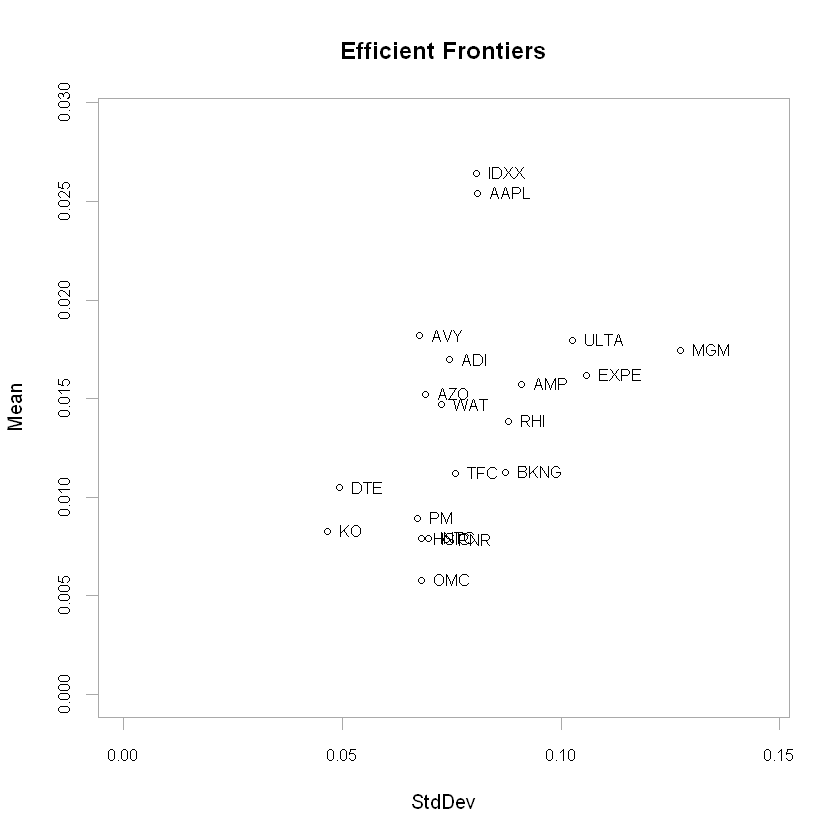

In [30]:
chart.EfficientFrontierOverlay(R = final_returns, portfolio_list = AB_comb, type = 'mean-var',
                               match.col = 'StdDev', rf = NULL, col = c("black", "red"), lty = c(1,1), lwd = c(1,1))

## Task 3

In [41]:
#getting the data required for task 3

task3_data <- vector("list", 20) #Empty list for the data


for (i in 1:20) { #Looping through the tickers
    ticker_volume <- paste(tickers_20[i,2], ".Volume", sep = "") #Pasting the tickers and variables together
    ticker_adjusted <- paste(tickers_20[i,2], ".Adjusted", sep = "") #so the full dataset can be subsetted
    ticker_bv <- paste(tickers_20[i,2], ".BV_per_share", sep = "")
    ticker_market <- paste(tickers_20[i,2], ".Market_Cap", sep = "")
    
    ticker_xts <- semifinal_dataset[, c(ticker_volume, ticker_adjusted, ticker_bv, ticker_market)]["2014-12/"] #Subsetting the full dataset

    task3_data[[i]] <- to.monthly(ticker_xts[,1], name = names(ticker_xts[,1]), OHLC = FALSE) #Extracting data from 2015 further and then converting it to monthly (averages??)
    task3_data[[i]] <- merge.xts(task3_data[[i]], to.monthly(ticker_xts[,2], name = names(ticker_xts[,2]), OHLC = FALSE))
    task3_data[[i]] <- merge.xts(task3_data[[i]], to.monthly(ticker_xts[,3], name = names(ticker_xts[,3]), OHLC = FALSE))
    task3_data[[i]] <- merge.xts(task3_data[[i]], to.monthly(ticker_xts[,4], name = names(ticker_xts[,4]), OHLC = FALSE))
}

Warning message in to.period(x, "months", indexAt = indexAt, name = name, ...):
"missing values removed from data"
Warning message in to.period(x, "months", indexAt = indexAt, name = name, ...):
"missing values removed from data"
Warning message in to.period(x, "months", indexAt = indexAt, name = name, ...):
"missing values removed from data"
Warning message in to.period(x, "months", indexAt = indexAt, name = name, ...):
"missing values removed from data"
Warning message in to.period(x, "months", indexAt = indexAt, name = name, ...):
"missing values removed from data"
Warning message in to.period(x, "months", indexAt = indexAt, name = name, ...):
"missing values removed from data"
Warning message in to.period(x, "months", indexAt = indexAt, name = name, ...):
"missing values removed from data"
Warning message in to.period(x, "months", indexAt = indexAt, name = name, ...):
"missing values removed from data"
Warning message in to.period(x, "months", indexAt = indexAt, name = name, ...):


In [43]:
#I think this is the best we can do :/

task3_data[[4]]

         WAT.Volume WAT.Adjusted WAT.BV_per_share WAT.Market_Cap
Dec 2014     193500       112.72            22.79           9.51
Jan 2015     582200       119.05               NA           9.88
Feb 2015     381800       120.38               NA           9.99
Mar 2015     299500       124.32            22.52          10.32
Apr 2015     684000       125.19               NA          10.34
May 2015     545900       133.62               NA          11.03
Jun 2015     634900       128.38            23.49          10.60
Jul 2015     593600       133.49               NA          10.95
Aug 2015     562700       121.38               NA           9.96
Sep 2015     583600       118.21            24.11           9.70
Oct 2015     467100       127.80               NA          10.52
Nov 2015     725600       132.82               NA          10.94
Dec 2015     318700       134.58            25.27          11.08
Jan 2016     599500       121.21               NA           9.85
Feb 2016     447500      